<h1>What is stixdcpy? </h1>
<p> stixdcpy allows  users to query and download data which are available at <a href="https://pub023.cs.technik.fhnw.ch/">STIX data center</a>, including </p> 
<ul>
<li> Quick-look light curves </li>
<li> Housekeeping data </li>
<li> Science data </li>
<li> Energy calibration data </li>
<li> Auxilary data </li>
<li> STIX solar flare list  </li>
 </ul>
<p>It also provides modules for use to preview the data. 
Note that data downloaded with stixdcpy are not validated. They should not be used for publication purpose. 
If you need validated data, please visit  solar orbiter data archive or contact us. 
</p>



# Install dependencies 

In [ ]:
!pip install git+https://github.com/drhlxiao/stixdcpy.git@analysis

  Cloning https://github.com/drhlxiao/stixdcpy.git (to revision analysis) to /tmp/pip-req-build-m8n8lgar
  Running command git clone -q https://github.com/drhlxiao/stixdcpy.git /tmp/pip-req-build-m8n8lgar
  Running command git checkout -b analysis --track origin/analysis
  Switched to a new branch 'analysis'
  Branch 'analysis' set up to track remote branch 'analysis' from 'origin'.
     |████████████████████████████████| 6.0 MB 15.1 MB/s 
     |████████████████████████████████| 257 kB 39.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.1 MB 48.7 MB/s 
     |████████████████████████████████| 94 kB 2.9 MB/s 
     |████████████████████████████████| 271 kB 63.6 MB/s 
     |████████████████████████████████| 144 kB 53.7 MB/s 
  Created wheel for stixdcpy: filename=stixdcpy-1.0.2-py3-none-any.whl size=42124 sha256=5e93dea2a18912c64ceae2944d47da2c6c682736f988dbfd07342

In [35]:
import sys


import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
import pandas as pd
from pprint import pprint

from astropy.table import QTable
from stixdcpy.quicklook import LightCurves
from stixdcpy.energylut import EnergyLUT
from stixdcpy import ancillary as anc
from stixdcpy.net import FitsQuery
from stixdcpy.net import JSONRequest as jreq
from stixdcpy import instrument as inst

from stixdcpy.science import ScienceL1, Spectrogram
from stixdcpy.housekeeping import Housekeeping
import matplotlib
#from plotly import __version__
%matplotlib inline

# Request Quick-look  data from STIX data center 

'ltc:  boolean, optional\n   True\n     do light time correction if it is True, default value = False\n'

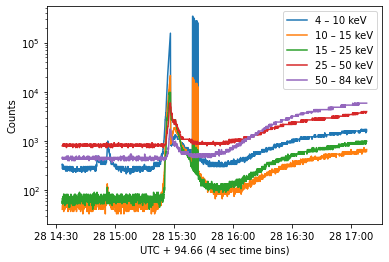

In [13]:

lc=LightCurves.fetch(start_utc='2021-10-28T15:00:00', end_utc='2021-10-28T17:00:00', ltc=True)
"""ltc:  boolean, optional
   True
     do light time correction if it is True, default value = False
"""
lc.peek()
#preview lightcurves


# Housekeep data

In [14]:
hk=Housekeeping.fetch('2021-02-14T05:00:00', '2021-02-14T07:00:00')
hk.param_names


{'NIX00020': 'SID',
 'NIX00072': 'Med value of trig acc',
 'NIX00073': 'Max value of trig acc',
 'NIX00076': 'Attenuator motions',
 'NIX00078': 'HK_ASP_PHOTOA0_V',
 'NIX00079': 'HK_ASP_PHOTOA1_V',
 'NIX00080': 'HK_ASP_PHOTOB0_V',
 'NIX00081': 'HK_ASP_PHOTOB1_V',
 'NIX00085': 'FDIR function status',
 'NIX00094': 'Attenuator currents',
 'NIXD0001': 'SW Version Number',
 'NIXD0002': 'CPU load',
 'NIXD0003': 'Archive Memory usage',
 'NIXD0004': 'IDPU identifier',
 'NIXD0005': 'Active SPW link',
 'NIXD0021': 'SW running',
 'NIXD0022': 'Instrument number',
 'NIXD0023': 'Instrument mode',
 'NIXD0024': 'HK_PSU_TEMP_T',
 'NIXD0025': 'HK_DPU_PCB_T',
 'NIXD0026': 'HK_DPU_FPGA_T',
 'NIXD0027': 'HK_DPU_3V3_C',
 'NIXD0028': 'HK_DPU_2V5_C',
 'NIXD0029': 'HK_DPU_1V5_C',
 'NIXD0030': 'HK_DPU_SPW_C',
 'NIXD0031': 'HK_DPU_SPW0_V',
 'NIXD0032': 'HK_DPU_SPW1_V',
 'NIXD0035': 'HK_DPU_1V5_V',
 'NIXD0036': 'HK_REF_2V5_V',
 'NIXD0037': 'HK_DPU_2V9_V',
 'NIXD0038': 'HK_ASP_REF_2V5A_V',
 'NIXD0039': 'HK_ASP_REF_

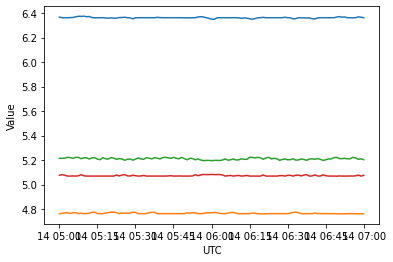

In [15]:

hk.plot('NIX00078,NIX00079,NIX00080,NIX00081')


# Calibration data

In [16]:
elut=EnergyLUT.request('2021-09-03T00:00:00')

In [17]:
#Print onboard elut and calibration run information
elut.info()
#elut.data


{'calibration_run': {'duration': 86400,
                     'obs_begin': '2021-09-02T12:56:17.958',
                     'run_id': 1353},
 'onboard_elut': {'upload_time_range': ['2021-06-25T14:54:14.456',
                                        '2021-06-25T14:55:49.456']}}


In [18]:
lut=elut.get_pixel_true_ebins(pixel=34)
#print the energy range of bins of pixel 34 
pd.DataFrame(lut)

,0,1
0,0.007,3.998
1,3.998,4.996
2,4.996,5.993
3,5.993,6.991
4,6.991,7.989
5,7.989,8.987
6,8.987,9.984
7,9.984,10.982
8,10.982,11.980
9,11.980,12.978


# S/C Ephemeris 

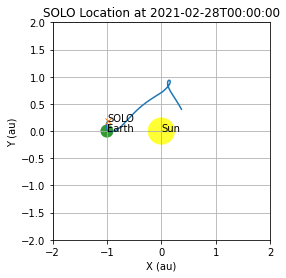

In [19]:
emph=anc.Ephemeris.fetch(start_utc='2021-02-28T00:00:00', end_utc='2021-12-28T01:00:00')
emph.peek()

In [20]:
emph.to_pandas()

,ref_frame,observer,aunit,lunit,vunit,tunit,utc,x,y,z,sun_solo_r,earth_solo_r,speed,owlt,light_time_diff,earth_sun_solo_angle,sun_angular_diameter,elevation
0,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-02-28T00:00:00Z,0.370631,0.401611,0.033408,0.547516,1.419545,28.962680,708.359970,221.055510,132.604266,58.397308,-3.491687
1,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-02-28T12:01:17Z,0.366733,0.408932,0.032485,0.550249,1.417997,28.736242,707.587311,219.752499,131.796362,58.107335,-3.378690
2,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-03-01T00:02:34Z,0.362826,0.416173,0.031549,0.553026,1.416464,28.507150,706.822485,218.427622,131.001179,57.815536,-3.265022
3,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-03-01T12:03:52Z,0.358914,0.423332,0.030598,0.555846,1.414949,28.275599,706.066081,217.081780,130.218730,57.522197,-3.150795
4,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-03-02T00:05:09Z,0.354999,0.430410,0.029634,0.558708,1.413451,28.041799,705.318719,215.715957,129.449062,57.227614,-3.036121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-12-26T00:54:50Z,-0.993682,0.170970,-0.017786,1.008440,0.172194,10.731207,85.925407,-12.445878,9.814188,31.706424,1.010414
602,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-12-26T12:56:07Z,-0.992451,0.173805,-0.018068,1.007717,0.174971,10.727680,87.311538,-12.094139,9.985743,31.729183,1.027208
603,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-12-27T00:57:25Z,-0.991176,0.176619,-0.018350,1.006956,0.177737,10.723936,88.691786,-11.722977,10.156841,31.753161,1.043989
604,SOLO_HEE_NASA,Earth,deg,au,km/s,s,2021-12-27T12:58:42Z,-0.989857,0.179413,-0.018630,1.006157,0.180491,10.719983,90.065953,-11.332412,10.327445,31.778363,1.060756


In [ ]:
#emph.data

# Science data

##  L1 data products

In [22]:
sci_data=ScienceL1.fetch(request_id=2105090003)
#Bulk science data request ids (also called unique ids) can be found on the science data web page at STIX data center

Shifted time bins corrected


In [23]:
hdul=sci_data.hdul
hdul.info()



Filename: /content/downloads/solo_L1A_stix-sci-xray-l1-2105090003_20210509T042711-20210509T044405_030772_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     31   1R x 8C   ['J', 'J', 'J', '3B', '3B', 'D', 'K', '32B']   
  2  DATA          1 BinTableHDU     45   51R x 12C   ['D', 'D', 'B', '144B', '32B', 'B', 'B', '16K', '16D', '12288D', '12288D', 'K']   
  3  ENERGIES      1 BinTableHDU     19   32R x 3C   ['K', 'D', 'D']   


Shifted time bins corrected


(<matplotlib.axes._subplots.AxesSubplot at 0x7f89930abbd0>,
 None,
 None)

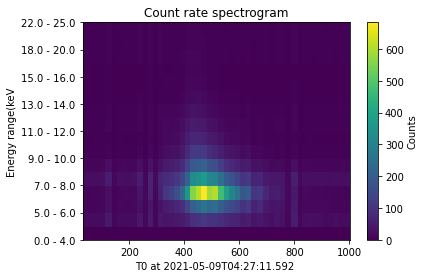

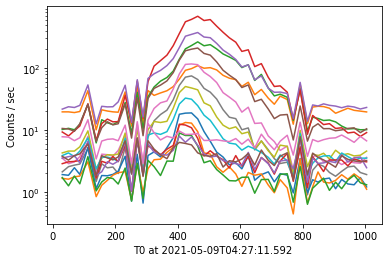

In [24]:
sci_data.peek('spg,lc')
#science data quicklook

## Spectrogram products

In [26]:
request_id=	2108150003
l4d=Spectrogram.fetch(request_id=request_id)
#fetch data from STIX data center

Shifted time bins corrected


Filename: /content/downloads/solo_L1A_stix-sci-spectrogram-2108150003_20210815T073948-20210815T083441_033101_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     39   1R x 11C   [J, J, J, 3B, 3B, D, J, 12B, 32B, K, 32B]   
  2  DATA          1 BinTableHDU     33   166R x 8C   ['D', 'D', 'B', 'K', 'D', '32D', '32D', 'K']   
  3  ENERGIES      1 BinTableHDU     19   32R x 3C   ['K', 'D', 'D']   


(<Figure size 576x432 with 5 Axes>,
 ((<matplotlib.axes._subplots.AxesSubplot at 0x7f8991caae50>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f8991c30bd0>),
  (<matplotlib.axes._subplots.AxesSubplot at 0x7f8991c5b1d0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7f899040b790>)))

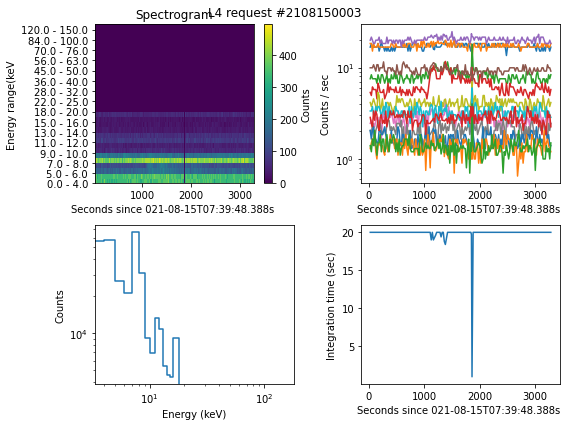

In [27]:
l4d.hdul.info()
l4d.peek()

# Data search and data download

In [57]:
#res=None
res=FitsQuery.query(start_utc='2021-05-04T05:00:00', stop_utc='2021-05-08T07:00:00',product_type='lc')
#print(res)

In [58]:
res.to_pandas()

,url,observation_time_range,creation_time,fits_id
0,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-03T23:59:58.849, 2021-05-04T23:59:58....",2022-02-04T14:53:08.690,23749
1,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-04T23:59:58.992, 2021-05-05T05:32:31....",2022-02-04T14:53:08.691,23750
2,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-03T23:59:58.849, 2021-05-04T23:59:58....",2022-02-04T14:53:14.666,23766
3,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-04T23:59:58.992, 2021-05-05T10:03:11....",2022-02-04T14:53:14.667,23767
4,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-05T10:03:11.053, 2021-05-05T23:59:59....",2022-02-04T14:53:20.859,23784
5,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-05T23:59:59.134, 2021-05-06T05:23:11....",2022-02-04T14:53:20.860,23785
6,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-05T14:33:51.080, 2021-05-05T23:59:59....",2022-02-04T14:53:24.121,23795
7,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-05T23:59:59.134, 2021-05-06T07:19:11....",2022-02-04T14:53:24.122,23796
8,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-06T07:19:11.180, 2021-05-06T23:59:59....",2022-02-04T14:53:28.858,23807
9,http://pub023.cs.technik.fhnw.ch/download/fits...,"[2021-05-06T23:59:59.176, 2021-05-07T20:03:11....",2022-02-04T14:53:28.859,23808


In [59]:
fits_list=res.fetch()

Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210504_023749_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210505_023750_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210504_023766_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210505_023767_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210505_023784_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210506_023785_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210505_023795_V01.fits ...
Found the data in local storage. Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210506_023796_V01.fits ...
Found the data in local storage. Filename: /cont

In [60]:
hduls=res.open_fits()


In [33]:
res.fits_info()

Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210728_025059_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     41   28R x 11C   [J, J, D, K, 32B, 12B, 33B, 3B, 3B, K, K]   
  2  DATA          1 BinTableHDU     33   16037R x 8C   [K, D, D, K, D, K, 5D, 5D]   
  3  ENERGIES      1 BinTableHDU     19   5R x 3C   [K, D, D]   
None
Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210728_025070_V01.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  CONTROL       1 BinTableHDU     41   10R x 11C   [J, J, D, K, 32B, 12B, 33B, 3B, 3B, K, K]   
  2  DATA          1 BinTableHDU     33   5563R x 8C   [K, D, D, K, D, K, 5D, 5D]   
  3  ENERGIES      1 BinTableHDU     19   5R x 3C   [K, D, D]   
None
Filename: /content/downloads/solo_L1A_stix-ql-lightcurve_20210729_025071_V01.fits
No.    Name      Ve

# Download flare list

In [36]:
flares=jreq.fetch_flare_list('2020-04-08T00:00:00',  '2021-12-09T00:00:00', sortedby='goes' )
#sort key can be LC0, LC1, LC2, LC3, LC4, time, goes

pd.DataFrame(flares)

,flare_id,total_signal_counts,total_counts,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,peak_counts,start_UTC,end_UTC,LC0_peak_counts_4sec
0,2110281540,4482016.0,4522441,220,2021-10-28T15:40:07.449,735.0,2657,M7.9,7.917655e-05,320.0,-550.0,148019.266667,2021-10-28T15:37:27.449,2021-10-28T15:41:07.450,344063
1,2108280604,208983536.0,209161583,2628,2021-08-28T06:04:24.583,271.0,1600,M4.8,4.785306e-05,1070.0,-1220.0,753663.000000,2021-08-28T05:53:24.582,2021-08-28T06:37:12.586,753663
2,2105071900,64493576.0,64596575,1668,2021-05-07T19:00:15.200,247.0,706,M3.9,3.908444e-05,540.0,270.0,306925.933333,2021-05-07T18:51:07.200,2021-05-07T19:18:55.202,311295
3,2110281030,7597264.0,7695754,536,2021-10-28T10:30:15.418,735.0,2650,M2.1,2.065525e-05,330.0,-640.0,125882.733333,2021-10-28T10:27:27.418,2021-10-28T10:36:23.419,221183
4,2111091653,21961904.0,22157034,3160,2021-11-09T16:53:03.716,247.0,2795,M2.0,2.019714e-05,0.0,0.0,54748.866667,2021-11-09T16:37:31.714,2021-11-09T17:30:11.720,55295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2110221527,792.0,10277,140,2021-10-22T15:27:35.968,271.0,2461,B3.4,3.416842e-07,NaN,NaN,335.000000,2021-10-22T15:26:07.968,2021-10-22T15:28:27.968,399
996,2109221009,18736.0,29604,176,2021-09-22T10:09:00.104,247.0,2060,B3.4,3.412554e-07,620.0,-820.0,1112.600000,2021-09-22T10:08:00.104,2021-09-22T10:10:56.104,1343
997,2109060150,6664.0,31611,404,2021-09-06T01:50:23.907,247.0,1768,B3.4,3.410783e-07,1610.0,-160.0,452.333333,2021-09-06T01:47:11.906,2021-09-06T01:53:55.907,495
998,2109100916,3528.0,113283,1620,2021-09-10T09:16:17.949,271.0,1887,B3.4,3.406701e-07,0.0,0.0,379.800000,2021-09-10T09:05:57.947,2021-09-10T09:32:57.950,463
